<center> <h1> Sentiment analysis on US political tweets and application to French political tweets during the 2017 French Presidential election </h1> </center>

Project done as part of the Machine Learning for Natural Language Processing course, given in the third year of the engineering cycle at ENSAE Paris, provided by Benjamin Muller (INRIA).

Authors: Clotilde Miura, Cédric Allain

April 12th, 2020

## Table of contents
1. [Introduction](#Introduction)
2. [Preprocessing and data exploration](#Preprocessing)
    - [Split into train/test](#Split)
    - [Tokenisation with Bert Tokenizer](#Tokenisation)
3. [Fine tune Bertmodel for sentiment classification](#Fine_tune)
    - [Define data loaders and training parameters](#Define_data_loaders)
    - [Training loop](#Trainin_loop)
    - [Evaluation](#Evaluation)
4. [Application to French tweets before the 2017 presidential election](#Application)
    - [Scrape the tweets](#Scrape)
    - [Translate the tweets into English](#Translate)
    - [Apply model to scraped tweets](#Apply_model)
    - [Score of popularity](#Score_popularity)

    



<a id='Introduction'></a>

## Introduction

- Nowadays, social media yield a growing influence on politics. Indeed, politicians consider Tweeter as a good indicator to assess their popularity. In this context, NLP, and particularly Sentiment Analysis, rises a growing interest. 

- This project aims at developping a sentiment model to predict the sentiment of a tweet among 3 different classes : negative, positive, and neutral. We used a dataset gathering tweets about the  2015 GOP debate (grand old party, i.e. the Republican Party). We decided to use BERT embeddding and fine tune it for our specific task. 

- To propose an originial applications, we decided to apply our model on French political tweets (previously translated in English) during the months preceding the 2017 Presidential Election, in order to asses the popularity of each candidate. 

- We will first preprocess the data, then fine Tune a pre trained embedding of BERT and evaluate it quantitatively and qualitatively. Finally, we will try to apply it to French tweets.

In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 35.1MB/s 
     |████████████████████████████████| 3.7MB 53.3MB/s 
     |████████████████████████████████| 1.0MB 55.1MB/s 
     |████████████████████████████████| 870kB 59.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=c059dba48b54e9f31f87ec925b64de22b947d9dbcaf4f1022bf0731f1bddf5fc
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# mount your drive to access the data
colab = True 
if colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# you must change the path to load the data on your computer 

# path: path to folder where all data are stored
# path_model: path to folder where the model is (going to be) saved

if colab:
  path = './drive/My Drive/NLP_ENSAE/NLP_project/data/'
  path_model = './drive/My Drive/NLP_ENSAE/NLP_project/'
else: 
  path = './data/'
  path_model = './'

# name of the model to be trained (or already saved)
model_name = 'sentiment_classifier'

In [0]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
import numpy as np 
import math
from tqdm import tqdm
import pickle

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes = True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from keras.preprocessing.sequence import pad_sequences

import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

<a id='Preprocessing'></a>

## Preprocessing and data exploration

- You must change the path to load the data on your environment execution . It can be for example './drive/Shared with me/NLP_project/data' or if you want to load the data in your own drive './drive/My Drive/....'
- You can also upload the csv file directly
- The data contains 13871 tweets and 20 different variables but we will only use the sentiment and text variables 

In [0]:
file = 'GOP_REL_ONLY.csv'
data = pd.read_csv(path+file, encoding='latin-1' )
print('shape data: ', data.shape)
data.head()

shape data:  (13871, 20)


,candidate,candidate:confidence,relevant_yn,relevant_yn:confidence,sentiment,sentiment:confidence,subject_matter,subject_matter:confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,8/7/15 9:54,6.296970e+17,NaN,Quito
1,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,8/7/15 9:54,6.296970e+17,NaN,NaN
2,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,8/7/15 9:54,6.296970e+17,NaN,NaN
3,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,8/7/15 9:54,6.296970e+17,Texas,Central Time (US & Canada)
4,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,8/7/15 9:54,6.296970e+17,NaN,Arizona


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   candidate                  13775 non-null  object 
 1   candidate:confidence       13871 non-null  float64
 2   relevant_yn                13871 non-null  object 
 3   relevant_yn:confidence     13871 non-null  float64
 4   sentiment                  13871 non-null  object 
 5   sentiment:confidence       13871 non-null  float64
 6   subject_matter             13545 non-null  object 
 7   subject_matter:confidence  13871 non-null  float64
 8   candidate_gold             28 non-null     object 
 9   name                       13871 non-null  object 
 10  relevant_yn_gold           32 non-null     object 
 11  retweet_count              13871 non-null  int64  
 12  sentiment_gold             15 non-null     object 
 13  subject_matter_gold        18 non-null     obj

In [0]:
def plot_counts(col, data, group=None,
                rotate_xticks=False, palette="Blues", figsize=(7,5)): 
    """For a categorical variable, plot the distribution of categories
    add the percentages on the graph countrary to seaborn function
    
    Parameters
    ----------
    col: string : name of variable

    data: dataframe of data 

    group: can plot percentages per group


    Returns
    -------
    None
    
    """
    fig, ax = plt.subplots(1, figsize=figsize)

    sns.countplot(x=col, data=data, hue=group, palette=palette,  ax=ax)

    if rotate_xticks == True:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    for j in range(len(ax.patches)):
        p = ax.patches[j]
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(data)),
                ha="center") 
        
    fig.tight_layout()

    return None

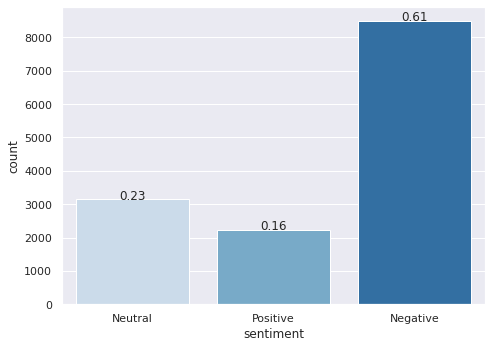

In [0]:
# distribution of the variable sentiment ie the target
plot_counts(col='sentiment', data=data)

We observe that we are in a situation of imbalanced data.
Indeed, there is way more negative tweets (61%) than positive or neutral ones (respectively 16% and 23%).

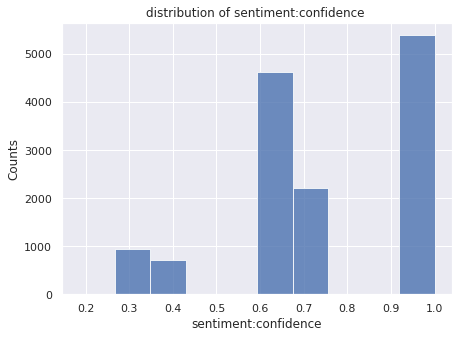

In [0]:
# distribution of sentiment confidence 
fig, ax = plt.subplots(1, figsize=(7,5))
data['sentiment:confidence'].hist(bins=10, alpha=0.8, ax=ax)
ax.set_xlabel('sentiment:confidence')
ax.set_ylabel('Counts')
plt.title('distribution of sentiment:confidence ')
plt.show()

In [0]:
data['sentiment:confidence'].describe()

count    13871.000000
mean         0.756936
std          0.217682
min          0.186000
25%          0.651700
50%          0.681300
75%          1.000000
max          1.000000
Name: sentiment:confidence, dtype: float64

- We do not know excately how the sentiment confidence was computed 
- We decide to discard tweets with confidence < 0.6

In [0]:
# discard tweets with sentiment confidence <0.6
data = data[data['sentiment:confidence']>=0.6]
print('new data shape:', data.shape)

new data shape: (12209, 20)


In [0]:
# some examples of tweets
print('neutral tweet:', data.loc[0, 'text'])
print('positive tweet:', data.loc[1, 'text'])
print('negative tweet:', data.loc[2, 'text'])

neutral tweet: RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
positive tweet: RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfFÛ_
negative tweet: RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.


<a id='Split'></a>

#### Split the data in train and test set 

- We use classicaly 75% of tweets for the train set 
- We fix the random_state to ensure reproductibility of results 

In [0]:
# split in train and test 
X, y = data.text, data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (9156,)
Test shape: (3053,)


In [0]:
y_train

7076     Negative
8294      Neutral
2338     Negative
1027     Negative
13858    Positive
           ...   
5552     Negative
3732     Positive
11220    Negative
12293    Positive
3119     Negative
Name: sentiment, Length: 9156, dtype: object

In [0]:
y_test

1823     Negative
13442    Positive
6815     Negative
4579     Negative
9472     Negative
           ...   
6968     Negative
7179     Negative
9106     Negative
2295      Neutral
12288    Negative
Name: sentiment, Length: 3053, dtype: object

In [0]:
# encode the labels
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [0]:
y_test

array([0, 2, 0, ..., 0, 1, 0])

The encoding is done as follow:
- 0 for negative tweets
- 1 for neutral ones 
- 2 for positive ones

<a id='Tokenisation'></a>

### Tokenisation with Bert Tokenizer

- <a href = 'https://huggingface.co/transformers/pretrained_models.html'> list of pretrained models  </a>
- We used bert-base-uncased:  12-layer, 768-hidden, 12-heads, 110M parameters.
Trained on lower-cased English text.

    
- Less number of tokens than with word to vec (vocabulary only contains around 30000 tokens)
- This is because BERT works at the subwords level. Therefore there are less  tokens
- BERTTokenizer does not remove ponctuation
- We will add  [CLS] token at the beginning of each sentence (understand sequence as a tweet not a real sentence ending with a point) and [SEP] at the end
- We will use some specific functions to preprocess tweets used in a Lab (remove html, url and hashtags)
- need to convert to id each tokens 
- the maximum len of tweets is 167 ==> We will padd all sequences with inferior length with 0 

In [0]:
# the maximum length BERT can handle is 512
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased') 
tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'],
                  data.text))
maxlen = np.max([len(seq) for seq in tokens])
print('max length:', maxlen)


max length: 167


In [0]:
class MyTokenizer():
    """Class wich will use BERT tokenizer 
    
    Parameters
    ----------
    tokenizer : BERT tokenizer from a given pretrained model

    maxlen : maxlen of sequences tolerated by BERT.
      We choose 167 as it is the maximum len of sequences.

    """

    def __init__(self, maxlen=167, from_pretrained='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(from_pretrained) 
        self.maxlen = maxlen
        

    def tokenize(self, text):
        '''
        Parameters
        ----------
        text: series of tweets 
        
        Returns
        -------
        tokens: the tokenized text ie array of shape (n, maxlen)
          where n is the number of sequences/tweets 

        '''
        tokens = list(map(lambda t: ['[CLS]'] + self.tokenizer.tokenize(t)[:maxlen-2] + ['[SEP]'],
                          text))
        tokens = [self.remove_html(seq) for seq in tokens]
        tokens = [self.remove_hashtags(seq) for seq in tokens]
        tokens = [self.remove_url(seq) for seq in tokens]
        
        # padding with zeros sequences with len <= maxlen
        # convert to id tokens
        tokens = pad_sequences(list(map(self.tokenizer.convert_tokens_to_ids,
                                        tokens)),
                               maxlen=self.maxlen,
                               truncating="post",
                               padding="post",
                               dtype='int')
        return tokens
        
        
    # special preprocessing for tweets
    
    @staticmethod
    def remove_html(tokens):
        tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
        return list(tokens)
    
    @staticmethod
    def remove_hashtags(tokens):
        tokens = map(lambda x: x.replace('#', ''), tokens)
        return list(tokens)
    
    @staticmethod
    def remove_url(tokens):
        tokens = filter(lambda x: "http" not in x, tokens)
        return list(tokens)

    
    

In [0]:
tokenizer = MyTokenizer(maxlen=maxlen)
train_tokens  = tokenizer.tokenize(X_train)
test_tokens = tokenizer.tokenize(X_test)

In [0]:
train_tokens.shape

(9156, 167)

In [0]:
print('size of the vocabulary:', tokenizer.tokenizer.vocab_size)

size of the vocabulary: 30522


##### Define torch tensor 

In [0]:
train_tokens_tensor = torch.tensor(train_tokens)
test_tokens_tensor = torch.tensor(test_tokens)

#### Compute the attention mask. 

- 1 if the token id is !=0 and 0 otherwise 

In [0]:
# attention masks. shape (n, maxlen).
train_masks_tensor = torch.tensor((train_tokens_tensor != 0).long())
print('train mask shape:', train_masks_tensor.shape)

test_masks_tensor = torch.tensor((test_tokens_tensor != 0).long())

train mask shape: torch.Size([9156, 167])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [0]:
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

<a id='Fine_tune'></a>

## Fine tune Bertmodel for sentiment classification

- For each sentence/tweet, the embedding of the [cls] token is extracted. The BERT embedding is in 768 dimensions.  
- Then we add on top of it a Dense layer of shape (768, 3) because we have 3 classes in our problem


In [0]:
class BertClassifier(nn.Module):
    def __init__(self, from_pretrained='bert-base-uncased'):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(from_pretrained)
        # dimension of the hidden state (768)
        self.hidden_dim = self.bert.pooler.dense.out_features 

        #self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.hidden_dim, 3)
        
        
    def forward(self, tokens, attn_masks=None):
        # pooled output is the encoding of CLS token
        #_, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        # Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.bert(tokens, attention_mask=attn_masks)

        # Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]
        logits = self.linear(cls_rep)

        return logits # don't use softmax activation as nn.CrossEntropy do it internally
    
    

<a id='Define_data_loaders'></a>

### Define data loaders and training parameters
- classical batch size of 4
- 5 epochs (sufficient to reach good results) . In the orgininal paper the authors only suggest a small number of epochs (2-4)
- set the tensors in cuda mode to use GPU of colab
- Criterion: we use the cross entropy of pytorch. It applies softmax to the logits and its formula is defined as follow

$$-\sum_{i=1}^n\sum_{k=1}^3\mathbb{1}_{y_i=k}log(p(y_i = k | x_i))$$

With n, the number of training samples, $y_i$ the class of observation, $x_i$ the embedded representation of obsevration i, and $p(y_i = k| x_i)$ the probability observation i belongs to class $k$, computed with softmax function

- Optimizer : Adam Optimizer, an adaptative method which compute different learning rates per feature and keeps in memory both first and second moment of the gradient of the loss. We use a small learning rate to avoid catastrophic forgetting. Using a too large reference learning rate (because learning rate in Adam is the product of a reference learning rate $\eta$ and a term with first and second moment of the gradient ) can lead to miss the minimum of the loss.

In [0]:
BATCH_SIZE = 4
EPOCHS = 5
gpu = True

train_dataset = TensorDataset(train_tokens_tensor,
                              train_masks_tensor,
                              y_train_tensor)
#train_sampler = RandomSampler(train_dataset)
#train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=5)

test_dataset = TensorDataset(test_tokens_tensor,
                             test_masks_tensor,
                             y_test_tensor)
#test_sampler = SequentialSampler(test_dataset)
#test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=5)

In [0]:
sentiment_model = BertClassifier()

criterion = nn.CrossEntropyLoss()

# adam optimizer 
optimizer = optim.Adam(sentiment_model.parameters(), lr=1e-5)

<a id='Training_loop'></a>

### Training loop

Remark: at the end of each epoch, the accuracy on all the train set is computed

WARNING  

Training the model is pretty long (about 20 minutes), make sure to download the saved model and to point at direction path_model under the name 'sentiment_classifier'.

In [0]:
%%time

n_train = train_tokens_tensor.shape[0]

def train_model(sentiment_model, gpu=True, EPOCHS=5, verbose=True):
  """
  
  """

  if gpu: 
    print('GPU mode')
    sentiment_model = sentiment_model.to("cuda")
    # optimizer has to be in cuda mode also
    optimizer = optim.Adam(sentiment_model.parameters(), lr=1e-5) 

  for ep in tqdm(range(EPOCHS)): # iterate over epochs
    list_preds = [] # list of predictions during this epochs
    list_labels = [] # list of true labels
    train_loss = 0

    # tweets is of shape (BATCH_SIZE, maxlen)
    for i, (tweets, attn_masks, labels) in enumerate(train_dataloader): 
        if gpu:
          # convert to cuda tensor
          tweets, attn_masks, labels = tweets.cuda(), attn_masks.cuda(), labels.cuda() 

        # Clear gradients
        optimizer.zero_grad()  
        
        #computes the logits with the forward pass
        logits = sentiment_model(tweets, attn_masks)

        # compute the predictions ie the class wich maximize the logits
        preds = torch.argmax(logits, axis=1).cpu().detach().numpy()
        #list_preds.append(list(preds))
        list_preds += list(preds)
        #list_labels.append(list(labels.detach().cpu().numpy())) # add labels to compute at the end of 
        list_labels += list(labels.detach().cpu().numpy())

        # Computing loss
        loss = criterion(logits, labels) # premier param = logits of shape (n_batch, n_class=3), 2e param = labels 
        train_loss+=loss.item()

        # Backpropagating the gradients
        loss.backward()

        # Optimization step
        optimizer.step()

        # monitoring 
        if i%100==0 and verbose:
          print('Iteration {} of epoch  {} completed'.format(i, ep))

    # monitoring 
    # print the accuracy of all the train set 
    accuracy = (np.array(list_preds) == np.array(list_labels)).sum()/n_train
    print('Epoch:', ep, 'loss:', train_loss, 'accuracy:', accuracy)

  return sentiment_model

if os.path.isfile(path_model + model_name):
  print('Model already exists. Loading of the model.')
  sentiment_model = BertClassifier()
  sentiment_model.load_state_dict(torch.load(path_model + model_name))
  # for unknown reason, when we load a saved model
  # we have to specify again the device
  sentiment_model.to('cuda')
else:
  print('Model does not exist yet. Training of the model.')
  sentiment_model = train_model(sentiment_model)
  torch.save(sentiment_model.state_dict(), path_model + model_name)


GPU mode


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration 0 of epoch  0 completed
Iteration 100 of epoch  0 completed
Iteration 200 of epoch  0 completed
Iteration 300 of epoch  0 completed
Iteration 400 of epoch  0 completed
Iteration 500 of epoch  0 completed
Iteration 600 of epoch  0 completed
Iteration 700 of epoch  0 completed
Iteration 800 of epoch  0 completed
Iteration 900 of epoch  0 completed
Iteration 1000 of epoch  0 completed
Iteration 1100 of epoch  0 completed
Iteration 1200 of epoch  0 completed
Iteration 1300 of epoch  0 completed
Iteration 1400 of epoch  0 completed
Iteration 1500 of epoch  0 completed
Iteration 1600 of epoch  0 completed
Iteration 1700 of epoch  0 completed
Iteration 1800 of epoch  0 completed
Iteration 1900 of epoch  0 completed
Iteration 2000 of epoch  0 completed
Iteration 2100 of epoch  0 completed
Iteration 2200 of epoch  0 completed


 20%|██        | 1/5 [03:55<15:41, 235.43s/it]

Epoch : 0 loss : 1442.841350659728 accuracy : 0.7362385321100917
Iteration 0 of epoch  1 completed
Iteration 100 of epoch  1 completed
Iteration 200 of epoch  1 completed
Iteration 300 of epoch  1 completed
Iteration 400 of epoch  1 completed
Iteration 500 of epoch  1 completed
Iteration 600 of epoch  1 completed
Iteration 700 of epoch  1 completed
Iteration 800 of epoch  1 completed
Iteration 900 of epoch  1 completed
Iteration 1000 of epoch  1 completed
Iteration 1100 of epoch  1 completed
Iteration 1200 of epoch  1 completed
Iteration 1300 of epoch  1 completed
Iteration 1400 of epoch  1 completed
Iteration 1500 of epoch  1 completed
Iteration 1600 of epoch  1 completed
Iteration 1700 of epoch  1 completed
Iteration 1800 of epoch  1 completed
Iteration 1900 of epoch  1 completed
Iteration 2000 of epoch  1 completed
Iteration 2100 of epoch  1 completed
Iteration 2200 of epoch  1 completed


 40%|████      | 2/5 [07:51<11:46, 235.59s/it]

Epoch : 1 loss : 805.0995346605778 accuracy : 0.863914373088685
Iteration 0 of epoch  2 completed
Iteration 100 of epoch  2 completed
Iteration 200 of epoch  2 completed
Iteration 300 of epoch  2 completed
Iteration 400 of epoch  2 completed
Iteration 500 of epoch  2 completed
Iteration 600 of epoch  2 completed
Iteration 700 of epoch  2 completed
Iteration 800 of epoch  2 completed
Iteration 900 of epoch  2 completed
Iteration 1000 of epoch  2 completed
Iteration 1100 of epoch  2 completed
Iteration 1200 of epoch  2 completed
Iteration 1300 of epoch  2 completed
Iteration 1400 of epoch  2 completed
Iteration 1500 of epoch  2 completed
Iteration 1600 of epoch  2 completed
Iteration 1700 of epoch  2 completed
Iteration 1800 of epoch  2 completed
Iteration 1900 of epoch  2 completed
Iteration 2000 of epoch  2 completed
Iteration 2100 of epoch  2 completed
Iteration 2200 of epoch  2 completed


 60%|██████    | 3/5 [11:48<07:51, 235.97s/it]

Epoch : 2 loss : 446.2581831216812 accuracy : 0.9262778505897772
Iteration 0 of epoch  3 completed
Iteration 100 of epoch  3 completed
Iteration 200 of epoch  3 completed
Iteration 300 of epoch  3 completed
Iteration 400 of epoch  3 completed
Iteration 500 of epoch  3 completed
Iteration 600 of epoch  3 completed
Iteration 700 of epoch  3 completed
Iteration 800 of epoch  3 completed
Iteration 900 of epoch  3 completed
Iteration 1000 of epoch  3 completed
Iteration 1100 of epoch  3 completed
Iteration 1200 of epoch  3 completed
Iteration 1300 of epoch  3 completed
Iteration 1400 of epoch  3 completed
Iteration 1500 of epoch  3 completed
Iteration 1600 of epoch  3 completed
Iteration 1700 of epoch  3 completed
Iteration 1800 of epoch  3 completed
Iteration 1900 of epoch  3 completed
Iteration 2000 of epoch  3 completed
Iteration 2100 of epoch  3 completed
Iteration 2200 of epoch  3 completed


 80%|████████  | 4/5 [15:43<03:55, 235.87s/it]

Epoch : 3 loss : 322.13973075151443 accuracy : 0.9438619484491044
Iteration 0 of epoch  4 completed
Iteration 100 of epoch  4 completed
Iteration 200 of epoch  4 completed
Iteration 300 of epoch  4 completed
Iteration 400 of epoch  4 completed
Iteration 500 of epoch  4 completed
Iteration 600 of epoch  4 completed
Iteration 700 of epoch  4 completed
Iteration 800 of epoch  4 completed
Iteration 900 of epoch  4 completed
Iteration 1000 of epoch  4 completed
Iteration 1100 of epoch  4 completed
Iteration 1200 of epoch  4 completed
Iteration 1300 of epoch  4 completed
Iteration 1400 of epoch  4 completed
Iteration 1500 of epoch  4 completed
Iteration 1600 of epoch  4 completed
Iteration 1700 of epoch  4 completed
Iteration 1800 of epoch  4 completed
Iteration 1900 of epoch  4 completed
Iteration 2000 of epoch  4 completed
Iteration 2100 of epoch  4 completed
Iteration 2200 of epoch  4 completed


100%|██████████| 5/5 [19:39<00:00, 236.00s/it]

Epoch : 4 loss : 289.1397498100996 accuracy : 0.9493228484054173


- After 5 epochs, we have an accuracy of 0.95 on all the train set. Which is very good. 

<a id='Evaluation'></a>

### Evaluation 

#### Quantitative evaluation on the test set

- As the problem is unbalanced, accuracy may not be the best metric. We need to evaluate the performaces on each classes anc chek the f1 score for example which is an harmonic average of the precision and the recall : 
$$f_1 = \frac{2 precision \times recall}{precision + recall }$$

In [0]:
%%time

sentiment_model.eval()
predictions = []

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):
        token_ids, masks, labels = tuple(t.to('cuda') for t in batch_data)
        # compute the predictions
        logits = sentiment_model(token_ids, masks)
        preds = torch.argmax(logits, axis=1).cpu().detach().numpy()
        predictions += list(preds)

predictions = np.array(predictions)

In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1993
           1       0.78      0.87      0.82       612
           2       0.91      0.85      0.88       448

    accuracy                           0.90      3053
   macro avg       0.88      0.88      0.88      3053
weighted avg       0.91      0.90      0.91      3053



- Performances are very good for the negative class. But we remind it's the majority one (61%)
- Nonetheless, neutral and positive class also have very good performances 
- Even if positive class represent a smaller proportion than neutral tweets (16% against 23%), performances are better globally (better for precision and F1 score). It might be because neutral tweets can be more difficult to classify than biased tweets because they are more ambiguous

#### Qualitative evaluation

- Check what kind of tweet are misclassified 


In [0]:
df_eval = pd.DataFrame({'tweet': X_test,
                        'prediction': predictions,
                        'y_true': y_test})
df_eval.head()

,tweet,prediction,y_true
1823,"RT @Jocklaflair: ""What about Black liv-...... ...",0,0
13442,RT @RWSurferGirl: FOX News won't admit who the...,0,2
6815,Does @realDonaldTrump believe he's gonna win r...,0,0
4579,RT @cristela9: Trump looks like an Oompa Loomp...,0,0
9472,RT @monaeltahawy: TwitterLand: has God spoken ...,1,0


In [0]:
# example of negative tweet misclassified in neutral one
df_eval.loc[9472, 'tweet']

'RT @monaeltahawy: TwitterLand: has God spoken to you about the #GOPDebates? What did she say?'

- even for a human it's not very clear the tweet is negative because of a lack of 'negative' words. A child wouldn't understand for example the tweet is negative

In [0]:
# example of positive tweet missclassified in negative one 
df_eval.loc[13442, 'tweet']

"RT @RWSurferGirl: FOX News won't admit who the Republican leader is right now I mean @realDonaldTrump only has a double-digit lead _Ùà¼_Ùàü #GOPD\x89Û_"

- Actually , we can't really understand why this tweet has been classified in a positive class in the first place. We would agree more with our classifier

<a id='Application'></a>

## Application to French tweets before the 2017 presidential election

- We will need to scrape those tweets 
- Then translate them into English 
- Best would have been to use directly a French embedding (e.g CamemBERT) and train the classification model on a corpus of French tweets but we coud not find such a dataset
- We use the package GetOldTweets3: no limitation in time or of  number of tweets 

<a id='Scrape'></a>

### Scrape the tweets

In [0]:
!pip install GetOldTweets3

- First round of presidential election : April the 23 rd 
- Candidates 
  - Emmanuel Macron 
  - Marine Le Pen 
  - Francois Fillon 
  - Jean Luc Melenchon
  - Benoit Hamon 
- We scraped the tweets published between the beginning of january and April the 23rd
- Need to select the tweets published in France. Problem : the geolocalisation is not always activated in Twitter and so there are a lot of tweets we cannot scrape by specifying the geolocalisation 
- Cannot use the encoding of emojis because we have error in translation..


In [0]:
import GetOldTweets3 as got

In [0]:
def scrape_tweets(candidate, n=1000):
  """Scrape the tweets for a given candidate one month before the first round of
  French Presidential election.

  Scrape only in France globally

  Parameters
  ----------
  candidate: sting
    name of a candidate
    values can be 'Macron', 'Melanchon', 'Fillon', 'Le Pen', 'Hamon'

  n: double
    number of tweets to scrape
    default is 1 000


  Returns
  -------
  tweets: list of scraped tweets

  """
  tweetCriteria = got.manager.TweetCriteria().setQuerySearch(candidate)\
                                            .setSince("2017-01-01")\
                                            .setUntil("2017-04-23")\
                                            .setMaxTweets(n)\
                                            .setNear('France')\
                                            .setWithin('1000km')
                                                                
  tweets = got.manager.TweetManager.getTweets(tweetCriteria)

  return tweets

In [0]:
%%time

# candidates names
candidates = ['Macron', 'Fillon', 'Le Pen', 'Melenchon', 'Hamon']
# number of tweets to scrap
n_scrape = 1000
# dictionary to stock scraped tweets
scraped_tweets = {}

for candidate in candidates:
  # Remove space and lower candidate's name
  name = candidate.replace(" ", "").lower()

  if os.path.isfile(path+'tweets_'+name):
    print("Scraped tweets already exists for " + candidate)
    tweets = pickle.load(open(path+'tweets_'+name,
                              'rb'))
  else:
    print("Scraping of " + candidate + "'s tweets")
    # scrape tweets
    tweets = scrape_tweets(candidate=candidate,
                          n=n_scrape)
    # save french tweets as pickle
    pickle.dump(tweets, open(path+'tweets_'+name, 'wb'))

  print('number of scraped tweets '+candidate+':', len(tweets))
  # declare global variable
  globals()['tweets_'+name] = tweets
  # append scraped dictionary
  scraped_tweets[name] = tweets

Scraped tweets already exists for Macron
number of scraped tweets Macron: 1000
Scraped tweets already exists for Fillon
number of scraped tweets Fillon: 1000
Scraped tweets already exists for Le Pen
number of scraped tweets Le Pen: 564
Scraped tweets already exists for Melenchon
number of scraped tweets Melenchon: 340
Scraped tweets already exists for Hamon
number of scraped tweets Hamon: 488
CPU times: user 23.5 ms, sys: 3.61 ms, total: 27.1 ms
Wall time: 777 ms


<a id='Translate'></a>

### Translate the tweets into English

Now that we scraped the tweets for the different politicans, we wish to translate them in english in order to apply the model trained previously.

To do so, we use the googletrans package, the package of Google Translate: https://pypi.org/project/googletrans/



In [0]:
!pip install googletrans

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=e5f0f69eb048b27506e7d3de9ff79fefa2f066597cdde26e7b6372388129f91c
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [0]:
from googletrans import Translator  
#from translate import Translator

In [0]:
translator = Translator()

def translate_into_english(tweets):
  """Tranlate a list of tweets into english.

  Parameters
  ----------
  tweets: list
    list of tweets to be translated


  Returns
  -------
  tweets_english: list
    list of tweets translated into english
  
  """
  tweets_english = []

  for tweet in tqdm(tweets):
    try:
      translated_tweet = translator.translate(tweet.text, dest='en').text
      tweets_english.append(translated_tweet)
    except:
      pass

  return tweets_english

In [0]:
%%time

# candidates names
candidates = ['macron', 'fillon', 'lepen', 'melenchon', 'hamon']
# dictionary to stock scraped tweets
scraped_tweets = {}
# dictionary to stock english tweets
english_tweets = {}

for candidate in candidates:

  if os.path.isfile(path+'tweets_'+candidate+'_english_v2'):
    print("English translation already exists for "+candidate+"s twwets")
    tweets_english = pickle.load(open(path+'tweets_'+candidate+'_english_v2',
                                      'rb'))
  else:
    # read tweets saved in pickle
    tweets = pickle.load(open(path+'tweets_'+candidate, 'rb'))
    print('nb scraped tweets '+candidate+':', len(tweets))
    # declare global variable
    globals()['tweets_'+candidate] = tweets
    # append scraped tweets dictionary
    scraped_tweets[candidate] = tweets
    # translate tweets
    tweets_english = translate_into_english(tweets)
    # save english tweets as pickle
    pickle.dump(tweets_english,
                open('tweets_'+candidate+'_english', 'wb'))

  print('nb english tweets '+candidate+':', len(tweets_english))
  # declare global variable
  globals()['tweets_'+candidate+'_english'] = tweets_english
  # append english dictionary
  english_tweets[candidate] = tweets_english
  

English translation already exists for macrons twwets
nb english tweets macron: 643
English translation already exists for fillons twwets
nb english tweets fillon: 470
English translation already exists for lepens twwets
nb english tweets lepen: 260
English translation already exists for melenchons twwets
nb english tweets melenchon: 114
English translation already exists for hamons twwets
nb english tweets hamon: 208
CPU times: user 6.92 ms, sys: 2.31 ms, total: 9.23 ms
Wall time: 1.4 s


<a id='Apply_model'></a>

### Apply model to scraped tweets

In [0]:
def get_predictions(candidate):
  """Get vecteurs of predictions for every tweet of a candidate.

  Parameters
  ----------
  candidate: string
    name of a candidate

  
  Returns
  -------
  predictions: list of integers
    list of 0, 1, 2, according of the sentiment predicted for each tweet

  """
  # get list of tweets
  tweets_candidate = globals()['tweets_'+candidate+'_english']
  # transform the list into a pandas Series
  X_candidate = pd.Series(tweets_candidate)
  # tokenize tweets
  candidate_tokens = tokenizer.tokenize(X_candidate)
  # prepare for predictions
  candidate_tokens_tensor = torch.tensor(candidate_tokens)
  candidate_masks_tensor = torch.tensor((candidate_tokens_tensor != 0).long())
  candidate_dataset = TensorDataset(candidate_tokens_tensor,
                                    candidate_masks_tensor)
  candidate_dataloader = DataLoader(candidate_dataset,
                                    batch_size=BATCH_SIZE,
                                    num_workers=5)
  # compute predictions
  predictions = []

  with torch.no_grad():
      for step_num, batch_data in enumerate(candidate_dataloader):
          token_ids, masks = tuple(t.to('cuda') for t in batch_data)
          # compute the predictions
          logits = sentiment_model(token_ids, masks)
          preds = torch.argmax(logits, axis=1).cpu().detach().numpy()
          predictions += list(preds)

  predictions = np.array(predictions)

  return predictions



In [0]:
%%time

candidates = ['macron', 'fillon', 'lepen', 'melenchon', 'hamon']

dict_predictions = defaultdict(list)

for candidate in tqdm(candidates):
  predictions = get_predictions(candidate)
  dict_predictions[candidate] = predictions

dict_predictions = dict(dict_predictions)

100%|██████████| 5/5 [00:22<00:00,  4.58s/it]

CPU times: user 15.2 s, sys: 6.65 s, total: 21.9 s
Wall time: 22.9 s


As a reminder, the encoding is done as follow:
- 0 for negative tweets
- 1 for neutral ones 
- 2 for positive ones

In [0]:
for candidate, predictions in dict_predictions.items():
  print("%s's predictions:" %candidate, Counter(predictions))

macron's predictions: Counter({1: 467, 0: 145, 2: 31})
fillon's predictions: Counter({1: 282, 0: 182, 2: 6})
lepen's predictions: Counter({1: 183, 0: 71, 2: 6})
melenchon's predictions: Counter({1: 82, 0: 30, 2: 2})
hamon's predictions: Counter({1: 136, 0: 65, 2: 7})


In [0]:
# creation of a DataFrame

labels = ['negative', 'neutral', 'positive']
encodings = [0, 1, 2]

dict_df = {'candidate': candidates,
           'negative': [],
           'neutral': [],
           'positive': [],
           'total': []}
          
for candidate in candidates:
  predictions = dict_predictions[candidate]
  count = dict(Counter(predictions))
  dict_df['total'].append(len(predictions))
  for label, val in zip(labels, encodings):
    dict_df[label].append(count[val])

df_pred = pd.DataFrame(data = dict_df)
df_pred.head()

,candidate,negative,neutral,positive,total
0,macron,145,467,31,643
1,fillon,182,282,6,470
2,lepen,71,183,6,260
3,melenchon,30,82,2,114
4,hamon,65,136,7,208


In [0]:
total_pred = df_pred[labels].sum().sum()
print("In total, we obtained %d predictions." %total_pred)
df_pred[labels].sum() / total_pred

In total, we obtained 1695 predictions.


negative    0.290855
neutral     0.678466
positive    0.030678
dtype: float64

- Here we can observe that tweets are rarely predicted as positive: less than 3% of translated tweets are predictited as such.
- Most of the time (>67%) tweets are predicted as neutral.

In [0]:
# show some example of tweets and their prediction

for candidate in candidates:
  print(candidate)
  predictions = dict_predictions[candidate]
  tweets_english = globals()['tweets_'+candidate+'_english']
  
  for label, val in [('negative', 0), ('neutral', 1), ('positive', 2)]:
    i = random.choices(np.argwhere(predictions==0))[0][0]
    print('predicted %s:' %label, tweets_english[i])

macron
predicted negative: @Mathieu_Gbt Baroin has no chance in front of Macron.
predicted neutral: journalists are never objective. Nobody is. Bcp reviews Macron fall fantasy
predicted positive: Macron’s team accuses RT, Sputnik of spreading false information ahead of French presidential poll: Emmanuel… http://dlvr.it/NY2yNL
fillon
predicted negative: Fillon cries conspiracy! He admits! s excuse! makes the costumes! repays the borrowed money! It's not me ! what credibility !!!
predicted neutral: and yet who twice asked to meet Sarkozy Fillon the loser of the UMP LR
predicted positive: yes and I will never forgive Fillon for his personal attacks against Sarkozy
lepen
predicted negative: paris | Paris Bourse: FRANCE 2017-Le Pen poses as a victim of the media and judges: M arine Le Pen ... http://dlvr.it/NTntYG
predicted neutral: think of the extreme left Le Pen ...
predicted positive: #LaFranceVoteMarine heiress Castle #Lepen #AttrapeTout, the biggest manipulative and thief clan of bill

When we look in details the tweets and their associated sentiment prediction, it can be seen that predictions are made in an absolute manner, as opposed to a prediction relative to the candidate.

This can be illustrated by the following tweet about E. Macron:
"@Mathieu_Gbt Baroin has no chance in front of Macron."
This tweet is a negative phrase, but is clearly in favour of E. Macron. However, it is categorized as negative because the prediction was made in an absolute and not relative manner by considering the candidate. Indeed, this same tweet can be categorized as positive for E. Macron, but as negative for F. Baroin.

Thus, a possible improvement would be to train a template with the text of the tweet, but adding a context variable that would be the subject of the tweet from which the "sentiment" of the tweet was determined.


<a id='Score_popularity'></a>

### Score of popularity

Now that we were able to apply our previously trained model on our scraped and translated tweets, we would like to compute a score a popularity for each candidate.

We would like the score to take both "absolute" results (i.e. the proportion of negative, neutral or positive tweets per candidate) and relative results (i.e. comparing these proportions to the proportions across all predictions).

To do this, the following formula is used for a given candidate.

$$\sum_{i} w_i \times p_i \times (p_i - \bar{p}_i)$$

where:
- $i$ is the label (negative, neutral, positive)
- $w_i$ is the weight associated for the label (respectively -1, 0.5 and 2)
- $p_i$ and $\bar{p}_i$ are the proportion of tweets predicted of the label respectively among the candidate's tweets and among all predictions

The weight vector [-1, 0.5, 2] (for "negative", "neutral" and "positive" respectively) was chosen for the following reason.
Instead of the "classical" weight vector [-1, 0, 1] in this kind of problem, we want to emphasize positive tweets, thus doubling their importance, but we also want to give importance to neutral tweets, without giving them the same importance as positive tweets.

In [0]:
def populatity_score(df_pred):
  """Compute the score of popularity for each candidate,
  from the predicted sentiment of tweets.

  Parameters
  ----------
  df_pred: pandas DataFrame
    columns:
      - 'candidate' (string), name of the candidate (macron, hamin, etc.)
      - 'negative' (resp. 'neutral' and 'positive') (integer),
        number of tweets predicted as negative (resp. neutral and positive) 
        for the candidate
      - 'total' (integer), total number of predictions
        (negative + neutral + positive) 

  Returns
  -------
  pop_score: dictionnary
    key: string, candidate name
    value: integer, popularity score

  """
  candidates = df_pred['candidate'].tolist()
  labels = ['negative', 'neutral', 'positive']
  weights = [-1, 0.5, 2]

  total_pred = df_pred[labels].sum().sum()
  percent_tot = dict(df_pred[labels].sum() / total_pred)

  dict_popularity = defaultdict()

  for candidate in candidates:
    score = 0
    for label, w in zip(labels, weights):
      n, t = df_pred[[label, 'total']][df_pred.candidate==candidate].iloc[0]
      p = n/t
      score += w * p * (p-percent_tot[label])
    
    dict_popularity[candidate] = score

  return dict(dict_popularity)

In [0]:
dict_popularity = populatity_score(df_pred)
dict_popularity

{'fillon': -0.06131823286608419,
 'hamon': -0.014612474581522412,
 'lepen': 0.01343590179958459,
 'macron': 0.03379170063963901,
 'melenchon': 0.02151322258448481}

Now that we have calculated the popularity scores of each candidate, we can look at the ranking that this gives us.
We can see that E. Macron is the one with the highest popularity score, followed by J.-L. Mélenchon and M. Le Pen. B. Hamon is further behind and F. Fillon is at the bottom of the ranking.

These results are rather close to those found in the presidential election, except for F. Fillon who came third.
This very low score for F. Fillon can perhaps be explained by the "Peneloppe gate" affair and by the fact his traditional electoral may not use social media .